In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from time import time
from matplotlib.animation import FuncAnimation
import multiprocessing
from sympy import symbols, solve

# Constantes
k_f, k_1, k_2, k_3, K_p = 28, 44, 26.5, 1.6, 0.18
R_1, r_2, R_3, r_4, R_5 = 6, 100, 50, 20, 1.6
V_p, J_leak = 1.2, 0.2

plt.rcParams.update({"font.size":20, "font.family":'Times New Roman'})

In [2]:
# Fonctions

def phi_1(c):
    """
        Calcul du taux phi_1, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_1
    """
    return r_2 * c / (R_1 + c)
def phi_1_inv(c):
    """
        Calcul du taux phi_-1, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_-1
    """
    return k_1 / (R_3 + c)
def phi_2(c):
    """
        Calcul du taux phi_2, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_2
    """
    return (k_2 + r_4*c) / (R_3 + c)
def phi_3(c):
    """
        Calcul du taux phi_3, en fonction de la concentration du calcium.
    Args :
        c : Concentration de calcium
    Returns :
        phi_3
    """
    return k_3 / (R_5 + c)

def J_pump(c):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        c : Concentration de calcium
    Returns :
        J_Pump
    """
    return (V_p * c**2) / (K_p**2 + c**2)
def J_receptor(c,h,p,kf=k_f):
    """
        Calcul du taux de calcium étant pompé dans la cellule.
    Args :
        c : Concentration de calcium
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
        kf : densité de récepteurs IP3 associé à chaque cellule
    Returns :
        J_Pump
    """
    return kf * ( (p*h*phi_1(c)) / (phi_1(c)*p + phi_1_inv(c)) )**4
def J_diffusion(c_1,c_2,D):
    """
        Calcul du taux de calcium diffusé entre deux cellules
    Args :
        c_1 : Concentration de calcium dans la cellule 1
        c_2 : Concentration de calcium dans la cellule 2
    Returns :
        J_Diffusion
    """
    return D*(c_2-c_1)

def J_diffusion2(c,interactions):
    """
        Calcul du taux de calcium diffusé entre plusieurs cellules
    Args :
        c : Concentration de calcium dans toutes les cellules (Matrice Nx1)
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN)
    Returns :
        J_Diffusion total pour chacune des cellules (Matrice Nx1)
    """
    return np.matmul(interactions,c)

def dc(c_1,c_2,h,p,D):
    """
        Équation différentielle du taux de variation de calcium pour un couplage de 2 cellules
    Args :
        c_1 : Concentration de calcium dans la cellule 1
        c_2 : Concentration de calcium dans la cellule 2
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
        D : Force de diffusion entre deux cellules
    Returns :
        dc/dt
    """
    return J_receptor(c_1, h, p) - J_pump(c_1) + J_leak + J_diffusion(c_1, c_2, D)

def dh(c,h,p):
    """
        Équation différentielle d'ordre 1 décrivant la fraction de récepteurs InsP3 ouverts ou fermés.
    Args :
        c : Concentration de calcium dans la cellule 2
        h : Fraction des récepteurs ouverts ou fermés
        p : Concentration d'InsP3
    Returns :
        dh/dt
    """
    return phi_3(c) * (1-h) - (phi_1(c)*phi_2(c)*h*p) / (phi_1(c)*p + phi_1_inv(c))

def one_cell(t,hc,c_2,p,D):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans une cellule.
    Args :
        t : Variable d'évolution temporelle
        hc : couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second 
    Returns :
        Comportement du système au temps t
    """
    h, c = hc
    return [dh(c,h,p), dc(c,c_2,h,p,D)]

def three_cell(t,hc,c_2,c_3,p,D):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans 3 cellules.
    Args :
        t : Variable d'évolution temporelle
        hc : couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second 
    Returns :
        Comportement du système au temps t
    """
    h, c = hc
    return [dh(c,h,p),J_receptor(c, h, p) - J_pump(c) + J_leak + D*(c_3-c) + D*(c_2-c)]

def multiple_cells(t,hc,interactions,p,kf,func_c_infuse):
    """
        Système d'équation différentielle d'ordre 1 décrivant le comportement de la concentration de calcium dans plusieurs cellules.
    Args :
        t : Variable d'évolution temporelle
        hc : Couple des valeurs initiales du système où h_0 et le premier élément et c_0 le second
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN)
        p : Concentrations d'InsP3 pour chacun des cellules
        kf : Densité de récepteurs IP3 associé à chaque cellule
        func_c_infuse : Liste de fonctions 'callable' pour une modification manuelle externe de la variation de calcium en fonction de t
    Returns :
        Comportement du système à plusieurs cellules au temps t
    """
    h = hc[:len(hc)//2]
    c = hc[len(hc)//2:]
    # c += np.array([c_mod(t) for c_mod in func_c_infuse])
    dh_val = dh(c,h,p)
    dc_val = J_receptor(c,h,p,kf) - J_pump(c) + J_leak + J_diffusion2(c,interactions) + np.array([c_mod(t) for c_mod in func_c_infuse])
    # if np.min(c) < 0:
    #     dc_val = np.abs(dc_val)
    # if np.min(h) < 0:
    #     dh_val = np.abs(dh_val)
    # elif np.max(h) > 1:
    #     dh_val = -1*np.abs(dh_val)
    # if np.min(c) <= -10000:
    #     c = c*0
    # if np.min(h) <= -10000 or np.max(h) >= 20000:
    #     h = h*0
    # print(np.array([c_mod(t) for c_mod in func_c_infuse]))
    all_val = list(dh_val) + list(dc_val)
    return all_val

def fill_interactions_matrix(interactions):
    """
        Remplissage de la matrice d'interactions. Elle doit être symétrique et la diagonale est la somme des autres éléments de la même ligne (ou colonne)
    Args :
        interactions : Matrice de la capacité d'échang entre toutes les cellules (Matrice NxN incomplète)
    Returns :
        Matrice d'interaction remplie
    """
    for n in range(0,interactions.shape[0]):
        for m in range(n+1,interactions.shape[0]):
            interactions[m,n] = interactions[n,m]
    for n in range(interactions.shape[0]):
        interactions[n,n] = -np.sum(interactions[n,:])
    return interactions

def graph_format_ax(ax):
    ax.tick_params(direction="in")
    

Nombre de CPU disponibles:  4
Cycle fixe: p=0.22, c=0.112
(0.22, -3.924622549316677)
(0.22, -3.929506178971601)
Cycle fixe: p=0.22, c=0.112
(0.22, -3.925271339498504)
(0.22, -3.9287361171528823)
Cycle fixe: p=0.2311111111111111, c=0.123
(0.2311111111111111, -3.923738883844186)
(0.2311111111111111, -3.928744021650993)
Cycle fixe: p=0.2311111111111111, c=0.123
(0.2311111111111111, -3.9232413469622522)
(0.2311111111111111, -3.9277935961244044)
Cycle fixe: p=0.24222222222222223, c=0.144
(0.24222222222222223, -3.922927576609594)
(0.24222222222222223, -3.9259497044314244)
Cycle fixe: p=0.24222222222222223, c=0.144
(0.24222222222222223, -3.9240840240937547)
(0.24222222222222223, -3.926474510120156)
Cycle fixe: p=0.25333333333333335, c=1.055
(0.25333333333333335, 0.41509245428124264)
(0.25333333333333335, 0.4144261059684885)
Cycle fixe: p=0.25333333333333335, c=1.056
(0.25333333333333335, 0.41529933032878735)
(0.25333333333333335, 0.4142803173671906)
Cycle fixe: p=0.2644444444444444, c=1.156
(

C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1994395925.py:48: RuntimeWarning: overflow encountered in scalar power
  return (V_p * c**2) / (K_p**2 + c**2)
C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1994395925.py:48: RuntimeWarning: invalid value encountered in scalar divide
  return (V_p * c**2) / (K_p**2 + c**2)
C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1994395925.py:48: RuntimeWarning: overflow encountered in scalar multiply
  return (V_p * c**2) / (K_p**2 + c**2)
C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1994395925.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return r_2 * c / (R_1 + c)
C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1994395925.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return (k_2 + r_4*c) / (R_3 + c)


Cycle fixe: p=0.3088888888888889, c=0.571
(0.3088888888888889, -2.973630064550237e+188)
(0.3088888888888889, -3.096803916094051e+188)
Cycle fixe: p=0.32, c=0.588
(0.32, -3.919704122592729)
(0.32, -3.922364919764862)
Cycle fixe: p=0.32, c=0.587
(0.32, -3.918610057748211)
(0.32, -3.9224062443768197)


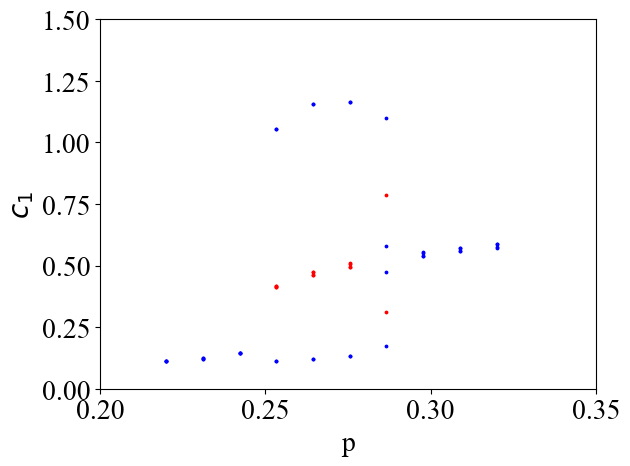

In [3]:
n_cpu = multiprocessing.cpu_count()//2
print("Nombre de CPU disponibles: ", n_cpu)

# Comportement d'une cellule avec c_2 constant
DIM_C = [0,1,1000]
DIM_H = [0,1,1000]
ps = [0.2,0.21,0.22,0.23,0.24,0.25,0.255,0.26,0.265,0.27,0.275,0.28,0.285,0.29,0.295,0.30,0.31,0.32]
ps = np.linspace(0.22,0.32,10)
# ps = np.linspace(0.245,0.255,10)
# ps = [0.2501]
Ds = [0.1]

c_1 = np.linspace(DIM_C[0],DIM_C[1],DIM_C[2])
h_1 = np.linspace(DIM_H[0],DIM_H[1],DIM_H[2])
c_2 = np.linspace(DIM_C[0],DIM_C[1],DIM_C[2])
h_2 = np.linspace(DIM_H[0],DIM_H[1],DIM_H[2])
c_2 = 0.1
H_1,C_1 = np.meshgrid(h_1,c_1)
t_span = [0,1000,10000]
t = np.linspace(t_span[0],t_span[1],t_span[2])
cycles_fixes = [] # (p,c)
cycles_fixes_instables = []
ch0 = [(0.53,0.6),(0.2,0.75)]
# 0.243
for p in  ps:
    for c_1_0, h_1_0 in ch0:
        # dc_1 = dc(C_1,c_2, H_1, p, Ds[0])
        # dh_1 = dh(C_1,H_1,p)

        # c_1_0 = 0.155
        # h_1_0 = 0.79

        # c_1_0 = 0.53
        # h_1_0 = 0.6

        # c_1_0 = 0.2
        # h_1_0 = 0.75

        # processe1 = multiprocessing.Process(target=solve_ivp, kwargs={"fun":one_cell, "t_span":t_span[:2], "y0":[h_1_0,c_1_0], "dense_output":True,"args":[c_2,p,Ds[0]]})
        # processe1.start()
        # processe1.join()
        sol = solve_ivp(one_cell,t_span[:2],[h_1_0,c_1_0],dense_output=True, args=[c_2,p,Ds[0]])
        sol_inv = solve_ivp(one_cell,[t_span[1], t_span[0]],[h_1_0,c_1_0],dense_output=True, args=[c_2,p,Ds[0]])
        h, c = sol.sol(t)
        h_inv, c_inv = sol_inv.sol(t)

        
        print(f"Cycle fixe: p={p}, c={round(np.max(c[-100:]),3)}")
        cycles_fixes.append((p,np.max(c[-100:])))
        cycles_fixes.append((p,np.min(c[-100:])))
        cycles_fixes_instables.append((p,np.max(c_inv[:100])))
        print(cycles_fixes_instables[-1])
        cycles_fixes_instables.append((p,np.min(c_inv[:100])))
        print(cycles_fixes_instables[-1])
        # print(h[-1], c[-1])
        # print(h[-1]-h[-2], c[-1]-c[-2])
        # plt.figure(figsize=(16,8))
        # fig, axs = plt.subplots(1,2)
        # axs[0].streamplot(H_1, C_1, dh_1, dc_1, density=1, linewidth=0.5, arrowsize=0.6, broken_streamlines=False,color="black",zorder=0)
        # axs[0].plot(h,c,color="red",zorder=1)
        # axs[0].plot(h[-100:], c[-100:], color="blue",zorder=2)
        # axs[0].plot(h_inv, c_inv, color="green",zorder=3,linewidth=1,alpha=1)
        
        # # plt.scatter(h_1[pt_fixes[1]], c_1[pt_fixes[0]],s=10,c="orange",alpha=1)
        # axs[0].set_xlabel('h')
        # axs[0].set_ylabel('c')
        # axs[0].set_xlim(0.5,0.9)
        # # plt.xlim([0.6,0.85])
        # axs[0].set_ylim(DIM_C[:2])
        # # plt.vlines([0.79],[0],[1])
        # axs[0].text(0,0.8,f"P={p}\nD={D}")
        # q=1000
        # axs[1].plot(t[:-q:-1],c_inv[:q-1])
        # plt.show()

p_cycle, c_cycle = list(zip(*cycles_fixes))
p_cycle_instable, c_cycle_instable = list(zip(*cycles_fixes_instables))
plt.scatter(p_cycle, c_cycle,s=3,c="blue")
plt.scatter(p_cycle_instable, c_cycle_instable, s=3,c="red")
plt.xlim([0.2,0.35])
plt.ylim([0,1.5])
plt.ylabel("$c_1$")
plt.xlabel("p")
plt.show()


In [4]:
def general(t_span, c0, h0, p, kf, interactions, c_mod):
    """
        Solutionne, pour toutes les cellules, le comportement dans le temps en plus des injections
    Args :
        t_span : Informations sur le temps d'échatillonage [Début, fin, nombre d'itérations]
        c0 : Concentrations initiales de toutes les cellules
        h0 : Fraction des récepteurs ouverts ou fermés initial pour toutes les cellules
        p : Concentrations d'InsP3 pour chacun des cellules
        kf : Densité de récepteurs IP3 associé à chaque cellule
        interactions : Matrice de la capacité d'échange entre toutes les cellules (Matrice NxN incomplète)
        c_mod : Liste de fonctions 'callable' pour une modification manuelle externe de la variation de calcium en fonction de t
    Returns :
        solution de l'équation différentielle
    """
    t = np.linspace(t_span[0], t_span[1],t_span[2])
    interactions = np.array(interactions)/100
    interactions = fill_interactions_matrix(interactions)
    # print(interactions)
    initial_values = np.array(h0+c0)

    # sol = solve_ivp(multiple_cells,t_span[:2],y0=initial_values,dense_output=True, args=[interactions,p,kf,c_mod]).sol(t)
    sol = solve_ivp(multiple_cells,t_span[:2],y0=initial_values,dense_output=True, args=[interactions,p,kf,c_mod],method="Radau").sol(t)
    return sol

def num_to_roman(n):
    """
        Converti un nombre format romain
    Args :
        n : Nombre à convertir
    Returns :
        Valeur de n en romain
    """
    # Ne devrait pas aller plus haut que 10 dans notre situation
    num = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X"]
    return num[n]

def graph_c_vs_t(sol, injections, N,t_span):
    """
        Trace le graphique de la concentration en fonction du temps de chacun des cellules
    Args :
        sol : Solution des équations différentielles de chacune des cellules
        injections : Liste des injections
        N : Nombre de cellules en jeu
    """
    colors = ["teal","darkviolet","black","red","green"]
    fig, ax = plt.subplots(N,1,figsize=(16,8),sharex=True)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    for n in range(N):
        last_injection_index = 0
        for injection in injections:
            indices = np.where((t>=injection[1]-injection[2]/2) & (t<=injection[1]+injection[2]/2))
            ax[n].plot(t[last_injection_index:indices[0][0]],sol[N+n][last_injection_index:indices[0][0]],alpha=1,color=colors[n%len(colors)])
            ax[n].plot(t[indices],sol[N+n][indices],alpha=1,linestyle="dashed",color=colors[n%len(colors)])
            last_injection_index = indices[0][-1]
        ax[n].plot(t[last_injection_index:],sol[N+n][last_injection_index:],alpha=1,color=colors[n%len(colors)],label=f"$c_{n+1}$")
        ymin, ymax = ax[n].get_ylim()
        xmin, xmax = ax[n].get_xlim()
        ax[n].set_xlim(0,t_span[1])
        ax[n].set_ylim(0,ymax)
        for num,injection in enumerate(injections):
            ax[n].fill_between(x=[injection[1]-injection[2]/2,injection[1]+injection[2]/2], y1=ymax,y2=0,alpha=0.5,color="grey")
            if n == 0: ax[n].text(injection[1],ymax,f"{num_to_roman(num)}",horizontalalignment='center',verticalalignment='bottom')
        graph_format_ax(ax[n])
        ax[n].legend(loc="upper right")
    # plt.text(-1,1,"Concentration c [$\mu M$]",rotation="vertical")
    plt.xlabel("Temps [s]")
    plt.ylabel("Concentration de Ca$^{2+}$ [$\mu M$]",loc="center")
    # plt.xlim([0,t_span[1]])
    # plt.legend()
    plt.show()

def graph_h_vs_t(sol, injections, N):
    """
        Trace le graphique de la concentration en fonction du temps de chacun des cellules
    Args :
        sol : Solution des équations différentielles de chacune des cellules
        injections : Liste des injections
        N : Nombre de cellules en jeu
    """
    colors = ["blue","orange","green","red","black"]
    fig, ax = plt.subplots(N,1,figsize=(16,8),sharex=True)
    plt.xlabel("Temps [s]")
    plt.ylabel("Concentration c")
    for n in range(N):
        last_injection_index = 0
        for injection in injections:
            indices = np.where((t>=injection[1]-injection[2]/2) & (t<=injection[1]+injection[2]/2))
            ax[n].plot(t[last_injection_index:indices[0][0]],sol[n][last_injection_index:indices[0][0]],alpha=1,color=colors[n%len(colors)])
            ax[n].plot(t[indices],sol[n][indices],alpha=1,linestyle="dashed",color=colors[n%len(colors)])
            last_injection_index = indices[0][-1]
        ax[n].plot(t[last_injection_index:],sol[n][last_injection_index:],alpha=1,color=colors[n%len(colors)],label=f"$c_{n+1}$")
        ymin, ymax = ax[n].get_ylim()
        ax[n].set_ylim(0,ymax)
        for num,injection in enumerate(injections):
            ax[n].fill_between(x=[injection[1]-injection[2]/2,injection[1]+injection[2]/2], y1=ymax,y2=0,alpha=0.5,color="grey")
            ax[n].text(injection[1],ymax,f"{num_to_roman(num)}",horizontalalignment='center',verticalalignment='bottom')
        graph_format_ax(ax[n])
        ax[n].legend(loc="upper right")
    
    plt.xlim([0,t_span[1]])
    # plt.legend()
    plt.show()


def animate_c_vs_h(N, sol):
    """
        Animation c vs h pour toutes les cellules
    Args :
        N : Nombre de cellules en jeu
        sol : Solution des équations différentielles de chacune des cellules
    """
    fig, ax = plt.subplots(figsize=(16,8))
    for n in range(N):
        plt.plot(sol[n],sol[N+n],label=f"$c_{n+1}$, $h_{n+1}$")
    plt.legend()
    points = []
    for n in range(N):
        points.append(ax.plot(sol[n][0],sol[N+n][0], marker="o")[0])
    def update(x):
        for n,point in enumerate(points):
            point.set_data([sol[n][x]],[sol[N+n][x]])
        return points
    ani = FuncAnimation(fig, update, interval=0.1, blit=True, repeat=True,
                        frames=100)
    plt.show()
    # ani.save("animation.gif")

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1879215350.py:68: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Concentration de Ca$^{2+}$ [$\mu M$]",loc="center")


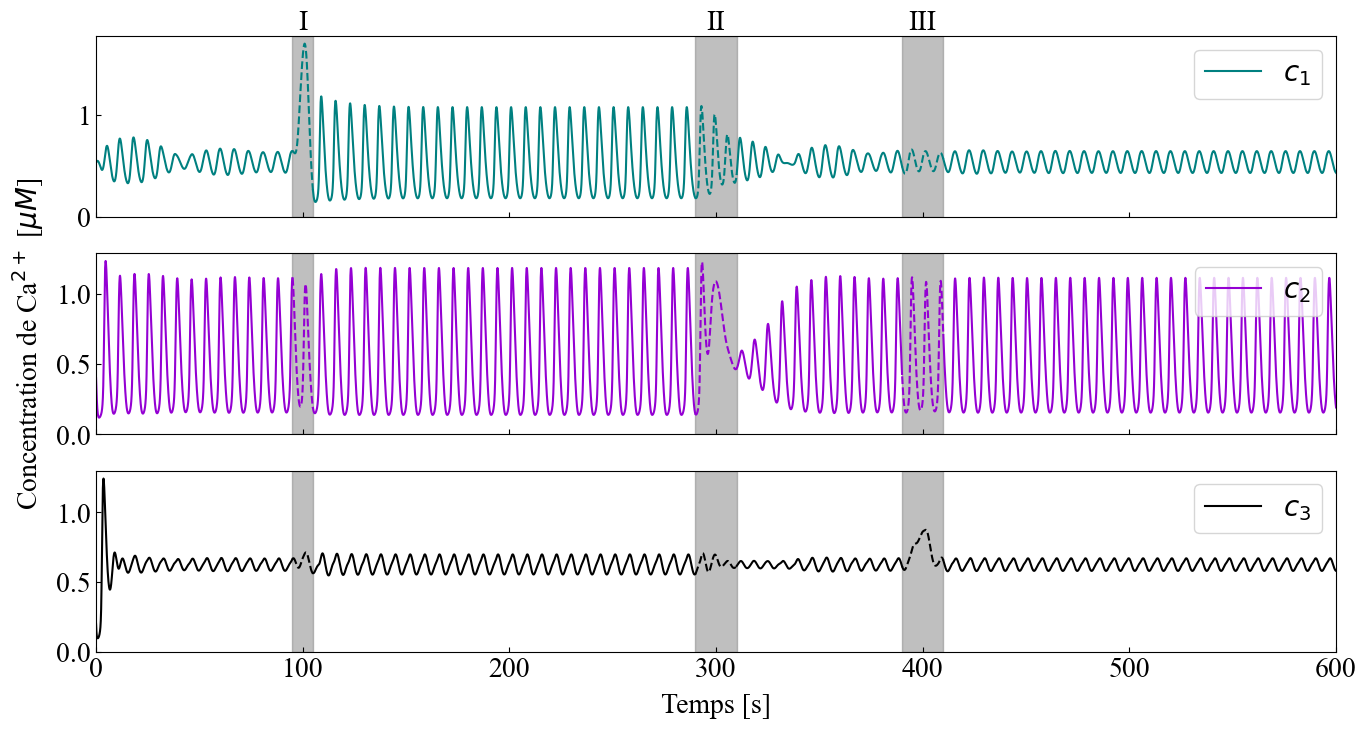

In [9]:
import multiprocessing.queues


def injection_gauss(t, positions, widths, amps):
    """
        Injection avec une évolution de type gaussienne
    Args :
        t : temps
        positions : Position des gaussiennes
        width : Valeur de référence pour sigma en plus de limiter le domaine de chacune des gaussiennes
        amps : Amplitude des gaussiennes
    Returns :
        Valeur de l'injection au temps t
    """
    somme, valid = 0, False
    for pos, width,amp in zip(positions,widths,amps):
        if ((t >= pos - width/2) and (t <= pos + width/2)): valid = True
        somme += amp*np.exp(-0.5*((t-pos)/(width/6))**2)
    if valid: return somme
    else: return 0

def get_solution_N_cell(N, t_span,c0,h0,p,kf,interactions,injections,graph=True):
    # Analyse injections pour analyse automatique de c_mod
    c_mod_dict = {}
    for n in range(1,N+1):
        c_mod_dict[f"{n}"] = {"Positions":[],"Widths":[],"Amplitudes":[]}
    for injection in injections:
        n = injection[0].replace("$","").replace("c_","")
        c_mod_dict[n] = c_mod_dict.get(n,{"Positions":[],"Widths":[],"Amplitudes":[]})
        c_mod_dict[n]["Positions"].append(injection[1])
        c_mod_dict[n]["Widths"].append(injection[2])
        c_mod_dict[n]["Amplitudes"].append(injection[3])
    c_mod_list = sorted(c_mod_dict.items())
    c_mod = [lambda x,mod=mod: injection_gauss(x,mod["Positions"],mod["Widths"],mod["Amplitudes"]) for n,mod in c_mod_list]
    # c_mod = [lambda x: injection_gauss(x,[600],[40],[-0.1]), lambda x: injection_gauss(x,[800],[40],[0.2]), lambda x: injection_gauss(x,[200,1000],[20,20],[0.3,0.3])]
    sol = general(t_span,c0,h0,p,kf,interactions,c_mod)
    t_span_inv = [t_span[1], t_span[0], t_span[2]]
    sol_inv = general(t_span_inv,c0,h0,p,kf,interactions,c_mod)
    # animate_c_vs_h(N,sol)
    if graph: graph_c_vs_t(sol, injections, N,t_span)
    # graph_c_vs_t(sol_inv, injections, N)
    # graph_h_vs_t(sol, injections, N)
    # graph_h_vs_t(sol_inv, injections, N)
    return sol, sol_inv

# General perturbations
N = 3
t_span = [0,600,10000]
t = np.linspace(t_span[0], t_span[1], t_span[2])
interactions = [[0,5,5],
                [0,0,5],
                [0,0,0]] # Les valeurs sont divisées par 100

c0 = [0.53,0.4, 0.2]
h0 = [0.6,0.5, 0.1]

p = np.array([0.27,0.26,0.33])
kf = np.array([28,28,28])

injections = [["$c_1$",100,10,1],["$c_2$",300,20,0.5],["$c_3$",400,20,0.3]] # [No. cellule, temps d'injection, durée de l'injection, amplitude injection] dans l'ordre chronologique
# injections = []
sol, sol_inv = get_solution_N_cell(N,t_span,c0,h0,p,kf,interactions,injections)



3 [0, 500, 1000] [0.53, 0.53, 0.53] [0.6, 0.6, 0.6] [0.23       0.23555556 0.24111111 0.24666667 0.25222222 0.25777778
 0.26333333 0.26888889 0.27444444 0.28      ] [28 28 28] [[0, 5, 5], [0, 0, 5], [0, 0, 0]] []
3 [0, 500, 1000] [0.53, 0.53, 0.53] [0.6, 0.6, 0.6] [0.23       0.23555556 0.24111111 0.24666667 0.25222222 0.25777778
 0.26333333 0.26888889 0.27444444 0.28      ] [28 28 28] [[0, 5, 5], [0, 0, 5], [0, 0, 0]] []


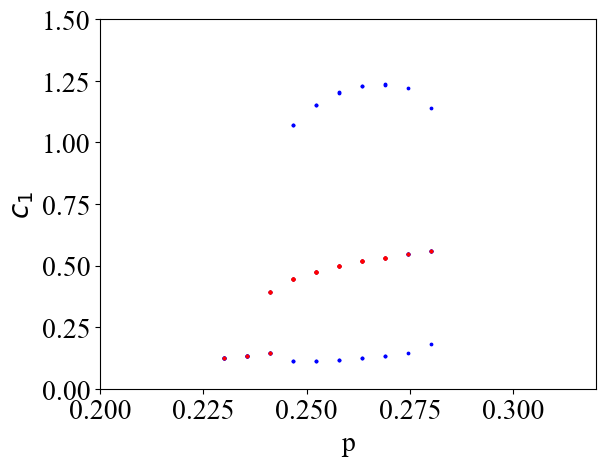

In [6]:
P = np.linspace(0.23,0.28,10)
# P = np.array([0.245,0.25,0.255])
cycles_fixes = [] # (p,c)
cycles_fixes_instables = []
N = 3
interactions = [[0,5,5],
                [0,0,5],
                [0,0,0]] # Les valeurs sont divisées par 100
t_span = [0,500,1000]
t = np.linspace(t_span[0], t_span[1], t_span[2])
c0 = [0.53,0.53, 0.53]
h0 = [0.6,0.6, 0.6]

kf = np.ones((N,))*28
kf = np.array([28,28,28])

injections = []

new_c0, new_h0 = [], []
new_c0_1, new_h0_1 = [], []
print(N,t_span,c0,h0,P,kf,interactions,injections)
for p in P:
    p = np.ones((N,))*p


    sol, sol_inv = get_solution_N_cell(N,t_span,c0,h0,p,kf,interactions,injections,graph=False)
    h, c = sol[0], sol[N]
    h_inv, c_inv = sol_inv[0], sol_inv[N]

    c_max,c_min = np.max(c[-100:]), np.min(c[-100:])
    c_inv_max, c_inv_min = np.max(c_inv[-100:]), np.min(c_inv[-100:])
    h_max,h_min = np.max(h[-100:]), np.min(h[-100:])
    h_inv_max, h_inv_min = np.max(h_inv[-100:]), np.min(h_inv[-100:])
    if c_inv_max >= 0 and c_inv_max < 1.5 and c_inv_max >= 0 and h_inv_max <= 1 and h_inv_max >= 0:
        new_c0.append(list(np.ones((N,))*(c_inv_max+c_inv_min)/2))
        new_h0.append(list(np.ones((N,))*(h_inv_max+h_inv_min)/2)) 
    else:
        new_c0.append(list(np.zeros((N,))))
        new_h0.append(list(np.zeros((N,)))) 
    if c_min >= 0 and c_max >= 0 and h_max <= 1 and h_max >= 0:
        new_c0_1.append(list(np.ones((N,))*(c_max+c_min)/2))
        new_h0_1.append(list(np.ones((N,))*(h_max+h_min)/2))
    else:
        new_c0_1.append(list(np.zeros((N,))))
        new_h0_1.append(list(np.zeros((N,))))

    # print(f"p={p}")
    cycles_fixes.append((p[0],c_max))
    # print(cycles_fixes[-1])
    cycles_fixes.append((p[0],c_min))
    # print(cycles_fixes[-1])
    cycles_fixes_instables.append((p[0],c_inv_max))
    # print(cycles_fixes_instables[-1])
    cycles_fixes_instables.append((p[0],c_inv_min))
    # print(cycles_fixes_instables[-1])
    q=100
    # plt.plot(h,c,color="red")
    # plt.plot(h_inv,c_inv,color="green")
    # plt.xlim([0,1])
    # plt.ylim([0,1.2])
    # plt.show()
N = 3
interactions = [[0,5,5],
                [0,0,5],
                [0,0,0]] # Les valeurs sont divisées par 100
t_span = [0,500,1000]
t_span_inv = [t_span[1], t_span[0], t_span[2]]
t = np.linspace(t_span[0], t_span[1], t_span[2])
injections = []
print(N,t_span,c0,h0,P,kf,interactions,injections)
for n,p in enumerate(P):
    p = np.ones((N,))*p
    c0 = new_c0[n]
    h0 = new_h0[n]

    sol, sol_inv = get_solution_N_cell(N,t_span,c0,h0,p,kf,interactions,injections,graph=False)
    h, c = sol[0], sol[N]
    h_inv, c_inv = sol_inv[0], sol_inv[N]

    c_max,c_min = np.max(c[-100:]), np.min(c[-100:])
    c_inv_max, c_inv_min = np.max(c_inv[-100:]), np.min(c_inv[-100:])
    # print(f"p={p}")
    cycles_fixes.append((p[0],c_max))
    # print(cycles_fixes[-1])
    cycles_fixes.append((p[0],c_min))
    # print(cycles_fixes[-1])
    cycles_fixes_instables.append((p[0],c_inv_max))
    # print(cycles_fixes_instables[-1])
    cycles_fixes_instables.append((p[0],c_inv_min))
    # print(cycles_fixes_instables[-1])
    q=100

    c0 = new_c0_1[n]
    h0 = new_h0_1[n]

    sol, sol_inv = get_solution_N_cell(N,t_span,c0,h0,p,kf,interactions,injections,graph=False)
    h, c = sol[0], sol[N]
    h_inv, c_inv = sol_inv[0], sol_inv[N]

    c_max,c_min = np.max(c[-100:]), np.min(c[-100:])
    c_inv_max, c_inv_min = np.max(c_inv[-100:]), np.min(c_inv[-100:])
    # print(f"p={p}")
    cycles_fixes.append((p[0],c_max))
    # print(cycles_fixes[-1])
    cycles_fixes.append((p[0],c_min))
    # print(cycles_fixes[-1])
    cycles_fixes_instables.append((p[0],c_inv_max))
    # print(cycles_fixes_instables[-1])
    cycles_fixes_instables.append((p[0],c_inv_min))
    # print(cycles_fixes_instables[-1])
    # plt.plot(h,c,color="red")
    # plt.plot(h_inv,c_inv,color="green")
    # plt.xlim([0,1])
    # plt.ylim([0,1.2])
    # plt.show()



p_cycle, c_cycle = list(zip(*cycles_fixes))
p_cycle_instable, c_cycle_instable = list(zip(*cycles_fixes_instables))

plt.scatter(p_cycle, c_cycle,s=3,c="blue")
plt.scatter(p_cycle_instable, c_cycle_instable, s=3,c="red")
plt.xlim([0.2,0.32])
plt.ylim([0,1.5])
plt.ylabel("$c_1$")
plt.xlabel("p")
plt.show()


C:\Users\Zacharie\AppData\Local\Temp\ipykernel_13380\1126154234.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(A, b)[0].squeeze()


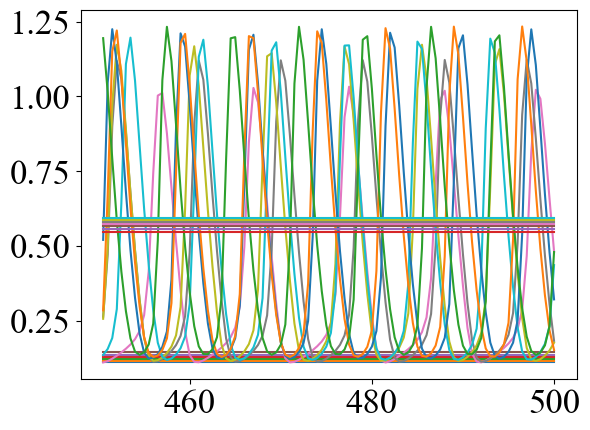

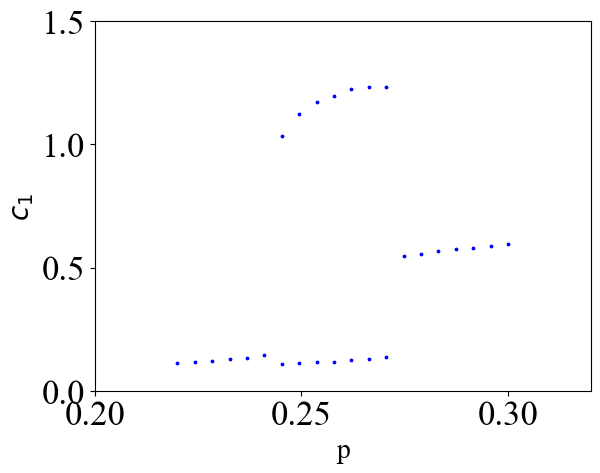

In [109]:
def fit_ellipse(pool,h,c):
    x = h[-pool:]
    y = c[-pool:]
    A = np.stack([x**2, x * y, y**2, x, y]).T
    b = np.ones_like(x)
    w = np.linalg.lstsq(A, b)[0].squeeze()
    xlin = np.linspace(0, 1, 300)
    ylin = np.linspace(0, 1.5, 300)
    X, Y = np.meshgrid(xlin, ylin)

    Z = w[0]*X**2 + w[1]*X*Y + w[2]*Y**2 + w[3]*X + w[4]*Y

    # Define the variables
    x, y = symbols('x y')

    # Given coefficients
    a = w[0]
    b = w[1]
    c = w[2]
    d = w[3]
    e = w[4]

    # Given constant term
    z = 0  # Assuming the constant term is zero

    # Given ellipse equation in polynomial form
    ellipse_equation = a*x**2 + b*x*y + c*y**2 + d*x + e*y - z

    # Solve for x and y to find the center point
    solution = solve((ellipse_equation.diff(x), ellipse_equation.diff(y)), (x, y))

    # print(solution.items())
    # print(list(solution.items())[0][1], list(solution.items())[1][1])

    # Extract the center point
    center = list(solution.items())
    center_point = (center[0][1], center[1][1])

    # print("Center point of the ellipse:", center_point)

    return center_point


P = np.linspace(0.22,0.30,20)
N = 3
interactions = [[0,5,5],
                [0,0,5],
                [0,0,0]] # Les valeurs sont divisées par 100
t_span = [0,500,1000]
t = np.linspace(t_span[0], t_span[1], t_span[2])
c0 = [0.6,0.6, 0.6]
h0 = [0.2,0.2, 0.2]
c0 = [0.53,0.53, 0.53]
h0 = [0.6,0.6, 0.6]
new_c0 = c0
new_h0 = h0

kf = np.array([28,28,28])

injections = []

bifurcation_points = []

stable_interval = 100

DEPTH = 1
for p in P:
    p = np.ones((N,))*p

    dep = 1
    while dep <= DEPTH:
        dep += 1
        # print(new_c0)
        sol, sol_inv = get_solution_N_cell(N,t_span,new_c0,new_h0,p,kf,interactions,injections,graph=False)
        h, c = sol[0:N], sol[N:]
        h_inv, c_inv = sol_inv[0:N], sol_inv[N:]
        plt.plot(t[-stable_interval:],c[0][-stable_interval:])

        if np.max(c[0][-stable_interval:])/np.min(c[0][-stable_interval:]) > 1.01:
            bifurcation_points.append((p[0],np.max(c[0][-stable_interval:])))
            bifurcation_points.append((p[0],np.min(c[0][-stable_interval:])))
            ellipse_center = fit_ellipse(pool=stable_interval,h=h[0],c=c[0])
            new_h0 = list(np.ones((N,))*ellipse_center[0])
            new_c0 = list(np.ones((N,))*ellipse_center[1])
        else:
            bifurcation_points.append((p[0],c[0][-1]))
            break
    # Add analysis for inverse solution
    new_c0 = c0
    new_h0 = h0
plt.show()
# print(bifurcation_points)
bif_p, bif_c = list(zip(*bifurcation_points))
plt.scatter(bif_p, bif_c,s=3,c="blue")
plt.xlim([0.2,0.32])
plt.ylim([0,1.5])
plt.ylabel("$c_1$")
plt.xlabel("p")
plt.show()

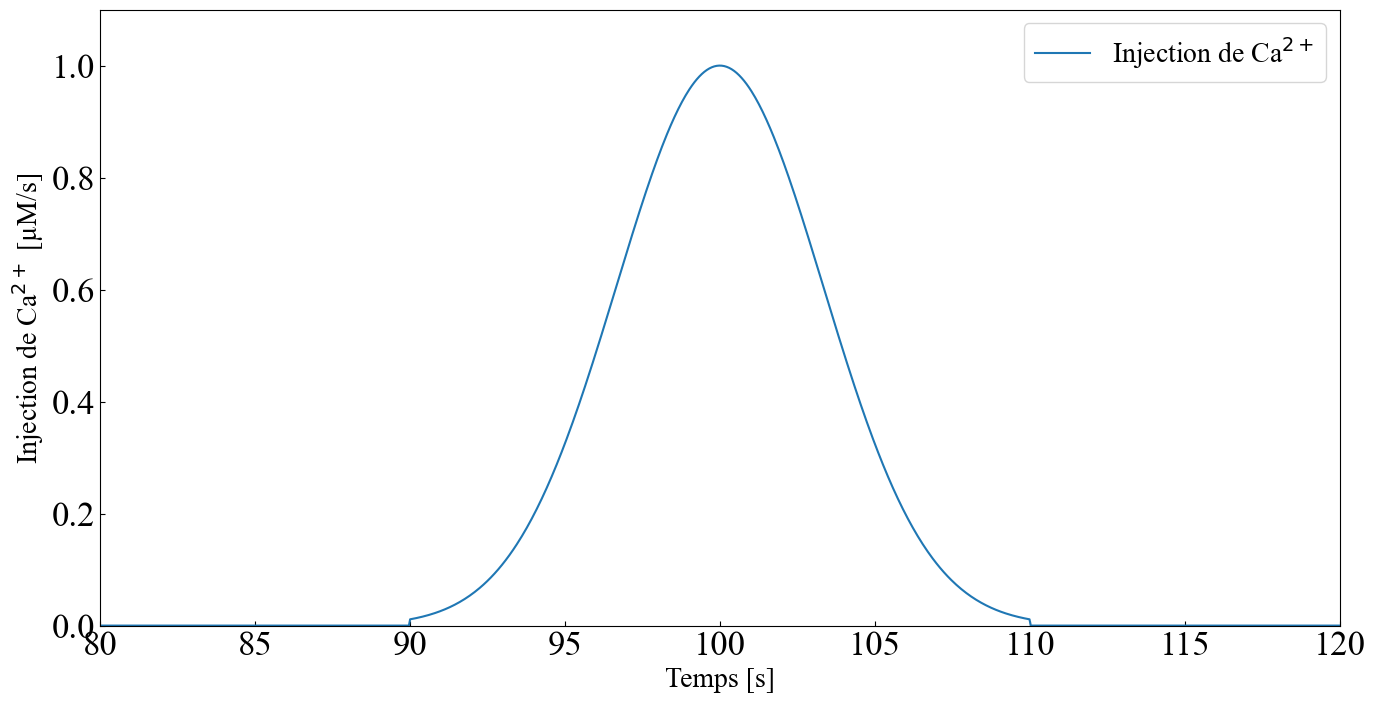

In [28]:
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
injections = [["$c_1$",100,20,1]]
T = np.linspace(80,120,1000)
dc_dt = []
# La fonction d'injection ne soutien pas les arrays, seulement int et floats
for t in T:
    dc_dt.append(injection_gauss(t,positions=[100],widths=[20],amps=[1]))

fig, ax = plt.subplots(1,1,figsize=(16,8))
graph_format_ax(ax)
ax.plot(T,dc_dt,label="Injection de Ca$^{2+}$")
ax.set_xlabel("Temps [s]")
ax.set_ylabel("Injection de Ca$^{2+}$ [µM/s]")
ax.set_xlim(80,120)
ax.set_ylim(0,1.1)
ax.legend()


